# Exploratory Data Analysis in European Soccer Leagues with SQLite3

with Eric Wolos

The objective of this project is to provide some quick practice using SQL queries and making good visualizations with data!

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
path = './euroSoccerDatabase.sqlite'

In [3]:
connection = sqlite3.connect(path)

In [4]:
query = lambda x: pd.read_sql_query(x, connection)

### First, what tables are in this dataset? What Leagues? What Seasons? Let's take a look.

In [5]:
query('''
SELECT * FROM sqlite_schema WHERE type= 'table' 
''')

,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,4,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,Player_Attributes,Player_Attributes,11,"CREATE TABLE ""Player_Attributes"" (\n\t`id`\tIN..."
2,table,Player,Player,14,CREATE TABLE `Player` (\n\t`id`\tINTEGER PRIMA...
3,table,Match,Match,18,CREATE TABLE `Match` (\n\t`id`\tINTEGER PRIMAR...
4,table,League,League,24,CREATE TABLE `League` (\n\t`id`\tINTEGER PRIMA...
5,table,Country,Country,26,CREATE TABLE `Country` (\n\t`id`\tINTEGER PRIM...
6,table,Team,Team,29,"CREATE TABLE ""Team"" (\n\t`id`\tINTEGER PRIMARY..."
7,table,Team_Attributes,Team_Attributes,2,CREATE TABLE `Team_Attributes` (\n\t`id`\tINTE...


In [6]:
query('''
SELECT DISTINCT season FROM MATCH
''')

,season
0,2008/2009
1,2009/2010
2,2010/2011
3,2011/2012
4,2012/2013
5,2013/2014
6,2014/2015
7,2015/2016


In [7]:
query("SELECT * FROM LEAGUE")

,id,country_id,name
0,1,1,Belgium Jupiler League
1,1729,1729,England Premier League
2,4769,4769,France Ligue 1
3,7809,7809,Germany 1. Bundesliga
4,10257,10257,Italy Serie A
5,13274,13274,Netherlands Eredivisie
6,15722,15722,Poland Ekstraklasa
7,17642,17642,Portugal Liga ZON Sagres
8,19694,19694,Scotland Premier League
9,21518,21518,Spain LIGA BBVA


### How did each team in the English Premier League do in the 2015/2016 season?

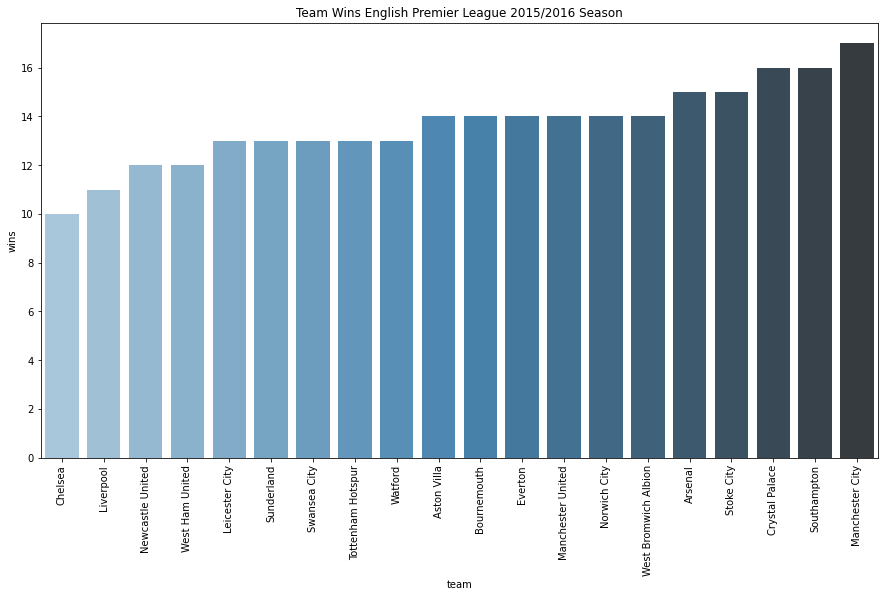

In [8]:
teamWins = query("""
SELECT home_team AS team, SUM(home_win + away_win) as wins FROM 
(SELECT MATCH.id, t1.team_long_name as home_team, t2.team_long_name as away_team,
(CASE 
WHEN home_team_goal > away_team_goal 
THEN 1 ELSE 0 
END) AS home_win,
(CASE WHEN home_team_goal = away_team_goal 
THEN 1 ELSE 0 
END) AS draw,
(CASE WHEN home_team_goal < away_team_goal 
THEN 1 ELSE 0 
END) AS away_win
FROM MATCH 
JOIN TEAM as t1 ON t1.team_api_id = MATCH.home_team_api_id 
JOIN TEAM as t2 ON t2.team_api_id = MATCH.away_team_api_id
WHERE league_id = 1729 AND season = '2015/2016')
GROUP BY home_team
ORDER BY wins
""")

plt.figure(figsize=(15,8))
sns.barplot(x='team', y = 'wins',data=teamWins, palette="Blues_d")
plt.xticks(rotation='vertical')
plt.title('Team Wins English Premier League 2015/2016 Season')
plt.show()

### What kind of distribution does player rating look like?

In [9]:
ratings = query('''
SELECT pl.player_name as name, pa.preferred_foot as pf_foot, SUM(overall_rating)/COUNT(*) as avg_rating
FROM PLAYER as pl
JOIN PLAYER_ATTRIBUTES AS pa
ON pa.player_api_id = pl.player_api_id
GROUP BY pl.player_name
''')

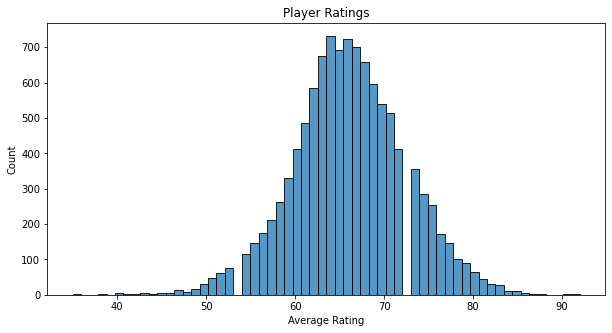

In [10]:
plt.figure(figsize=(10,5))
plt.title('Player Ratings')
sns.histplot(data = ratings['avg_rating'], bins=60)
plt.xlabel('Average Rating')
plt.ylabel('Count')
plt.show()

### Are more players right footed than left footed? Is there a difference between right/left footedness rankings?

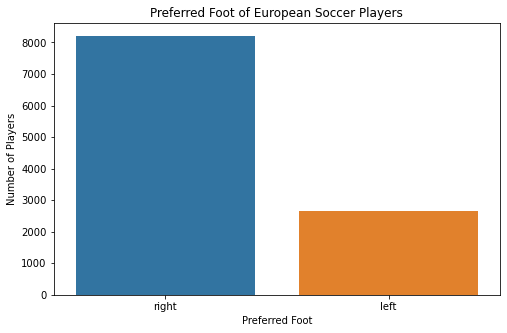

In [11]:
counts = ratings['pf_foot'].value_counts()
plt.figure(figsize=(8,5))
sns.barplot(x= counts.index, y = counts,data = pd.DataFrame(counts))
plt.xlabel('Preferred Foot')
plt.ylabel('Number of Players')
plt.title('Preferred Foot of European Soccer Players')
plt.show()

As expected, looks like more players are right footed.

In [12]:
left_ratings = query('''
SELECT avg_rating FROM 
(SELECT pl.player_name as name, pa.preferred_foot as pf_foot, SUM(overall_rating)/COUNT(*) as avg_rating
FROM PLAYER as pl
JOIN PLAYER_ATTRIBUTES AS pa
ON pa.player_api_id = pl.player_api_id
GROUP BY pl.player_name) WHERE pf_foot = 'left'
''')

right_ratings = query('''
SELECT avg_rating FROM 
(SELECT pl.player_name as name, pa.preferred_foot as pf_foot, SUM(overall_rating)/COUNT(*) as avg_rating
FROM PLAYER as pl
JOIN PLAYER_ATTRIBUTES AS pa
ON pa.player_api_id = pl.player_api_id
GROUP BY pl.player_name) WHERE pf_foot = 'right'
''')

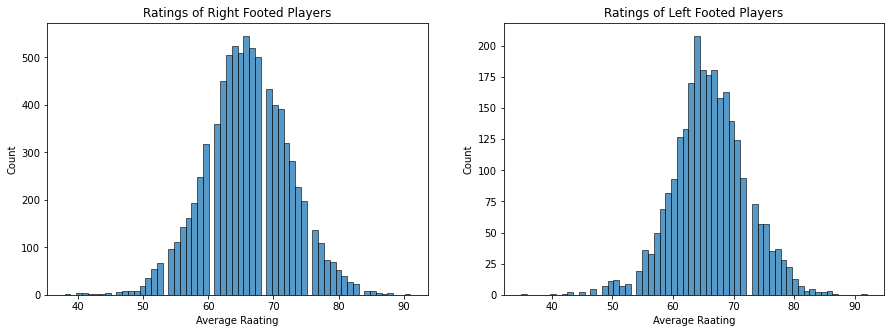

In [13]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title('Ratings of Right Footed Players')
sns.histplot(data = right_ratings['avg_rating'], bins=60)
plt.xlabel('Average Raating')
plt.ylabel('Count')
plt.subplot(1,2,2)
plt.title('Ratings of Left Footed Players')
sns.histplot(data = left_ratings['avg_rating'], bins=60)
plt.xlabel('Average Raating')
plt.ylabel('Count')
plt.show()

In [14]:
np.median(right_ratings) == np.median(left_ratings)

True

Not only is the median rating of left and right footed players the same, their distributions look similar too!

### Is there a trend in games with goals scored with headers?

In [15]:
gamesWithHeaders = query(
'''
SELECT season, 1.0*COUNT(goal)/(SELECT COUNT(*) FROM MATCH GROUP BY season) as goals 
FROM Match 
WHERE goal LIKE '%header%'
GROUP BY season
''')

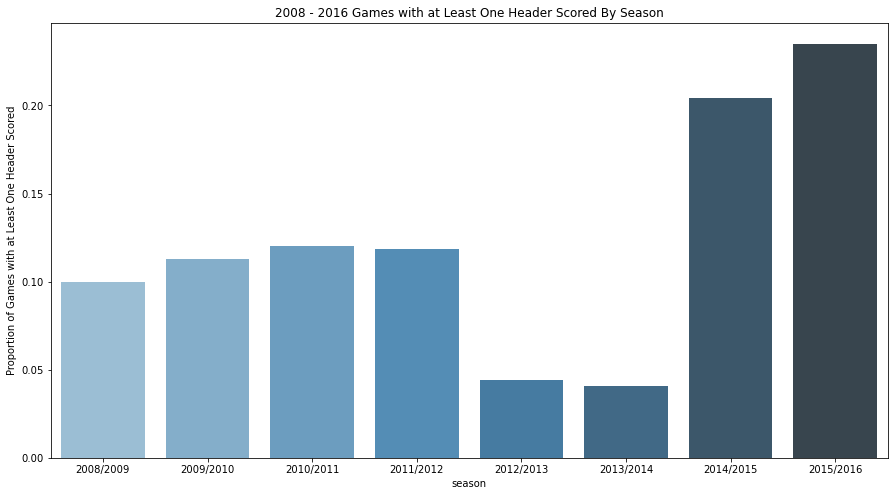

In [16]:
plt.figure(figsize=(15,8))
sns.barplot(x = 'season', y='goals', data = gamesWithHeaders, palette = "Blues_d")
plt.ylabel('Proportion of Games with at Least One Header Scored')
plt.title('2008 - 2016 Games with at Least One Header Scored By Season')
plt.show()

Looks like there was a lull in games with headers for the 2012/2013 and 2013/2014 seasons, but then a quick recovery afterwards.

### Are Taller Players Heavier?

In [17]:
height_and_ratings = query('''
SELECT pl.player_name as name, pl.height, pl.weight, SUM(overall_rating)/COUNT(*) as avg_rating
FROM PLAYER as pl
JOIN PLAYER_ATTRIBUTES AS pa
ON pa.player_api_id = pl.player_api_id
GROUP BY pl.player_name
''')

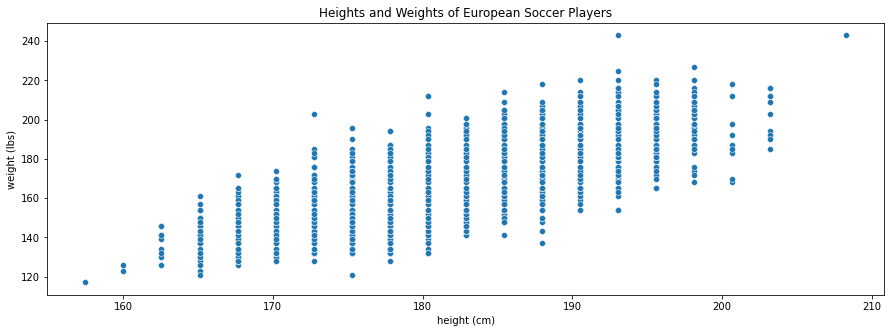

In [18]:
plt.figure(figsize=(15,5))
sns.scatterplot(data=height_and_ratings, x = 'height', y = 'weight')
plt.xlabel('height (cm)')
plt.ylabel('weight (lbs)')
plt.title('Heights and Weights of European Soccer Players')
plt.show()

In [19]:
correlation_matrix = np.corrcoef(height_and_ratings['weight'], height_and_ratings['height'])

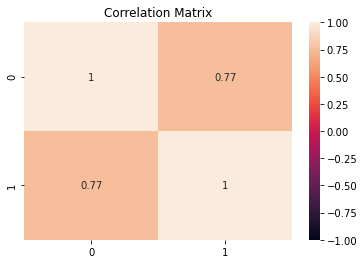

In [20]:
sns.heatmap(correlation_matrix,annot=True,vmin=-1,vmax=1)
plt.title('Correlation Matrix')
plt.show()

There seems to be some sort of correlation!

### Is there a trend in games with yellow or red cards?

In [21]:
gamesWithCards = query(
'''
SELECT season, 1.0*COUNT(goal)/(SELECT COUNT(*) FROM MATCH GROUP BY season) as goals 
FROM Match 
WHERE card LIKE '%>y<%' OR card LIKE '%>r<%'
GROUP BY season
''')

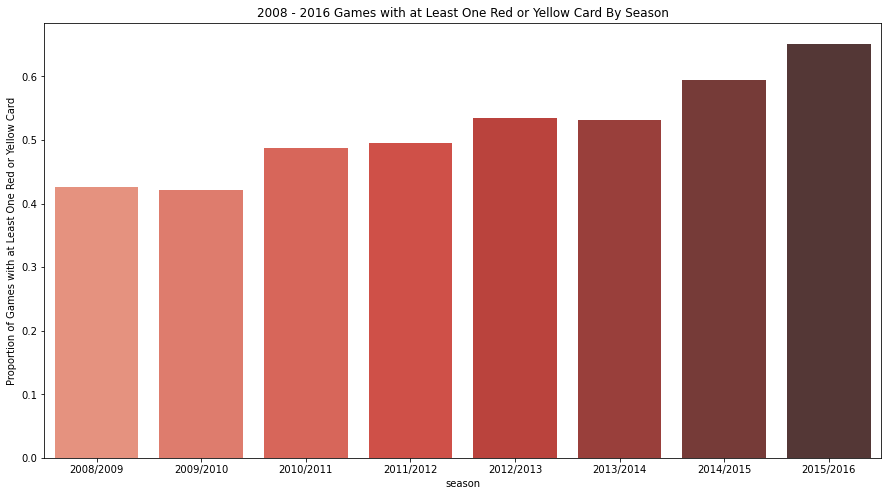

In [22]:
plt.figure(figsize=(15,8))
sns.barplot(x = 'season', y='goals', data = gamesWithCards, palette = "Reds_d")
plt.ylabel('Proportion of Games with at Least One Red or Yellow Card')
plt.title('2008 - 2016 Games with at Least One Red or Yellow Card By Season')
plt.show()

Looks like there have been a greater number of yellow or red cards given out as time has progressed in this dataset.